# Transfer Learning Dogs and Cats | Primeiro Desafio de Projeto

Com o intuito de colocar em prática os aprendizados obtidos no projeto demostrativo de Transfer Learning do primeiro desafio de projeto do Bootcamp DIO BairesDEV Machine Learning Practitioner, realizo agora um passo a passo das etapas necessárias para o manejo, tratamento e classificação de imagens utilizando o algorítimo de detecção e classificação de objetos VGG16.

*Aimming to put into practice the knowledge obtained within the demo project in Transfer Learning of the first project challenge from DIO & BairesDev Machine Learning Practitioner Bootcamp, i now present a step-by-step representation of necessary handling, treatment and classification of images using the VGG16  object detection and classification algorithm.*

Primeiramente faremos a importação das mesmas dependencias e bibliotecas usadas no projeto demo, com a explicação do porque os respectivos módulos estão sendo utilizados.

*First, we will import the same dependencies and libraries used in the demo project, along with an explanation of why each respective module is being utilized.*

***Nota importante: o Google mudou seu ambiente para usar TPUs para projetos de aprendizado de máquina. O código abaixo que foi extraído de
[TPUs no Colab - Martin Gorner](https://colab.research.google.com/notebooks/tpu.ipynb#scrollTo=ovFDeMgtjqW4)
prepara o ambiente para treinar o modelo no novo ambiente TPU do Google***

***Important Note: Google changed its enviroment to use TPUs for machine learning projects. The code below that is extracted from
[TPUs in Colab - Martin Gorner](https://colab.research.google.com/notebooks/tpu.ipynb#scrollTo=ovFDeMgtjqW4)
prepares the enviroment to train the model on Google's new TPU enviroment***

In [ ]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)


'''
Verifica um ambiente de execução TPU e resolve o cluster, recuperando o número de núcleos TPU disponíveis para computação.
Garante que você tenha acesso a uma TPU e seus recursos.

Checks for a TPU runtime environment and resolves the cluster and retrieves the number of TPU cores available for computation.
Ensures you have access to a TPU and its resources.
'''
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print(f'Running on a TPU w/{tpu.num_accelerators()["TPU"]} cores')
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

'''
Conecta o TensorFlow ao cluster TPU encontrado pelo TPUClusterResolver.
Inicializa o sistema TPU. Esta etapa é obrigatória para preparar o TPU para computação distribuída.
Cria uma estratégia de treinamento distribuída usando o TPU. TPUStrategy é uma API do TensorFlow que simplifica o processo de treinamento de modelos em vários núcleos TPU.

Connects TensorFlow to the TPU cluster found by the TPUClusterResolver.
Initializes the TPU system. This step is mandatory to prepare the TPU for distributed computation.
Creates a distributed training strategy using the TPU. TPUStrategy is a TensorFlow API that simplifies the process of training models across multiple TPU cores.
'''

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Tensorflow version 2.15.0
Running on a TPU w/8 cores


In [ ]:
"""
%matplotlib inline -
            ativação da plotagem inline do matplotlib |
            inline plotting with matplotlib
"""
%matplotlib inline

"""
import os - módulo python para interaçao com o sistema operacional e fornece
            manipulação de arquivos e diretórios |
            python module that provides functions for interacting with the
            operating system and file and directory handling
"""
import os

"""
import random -
                módulo python para geração de números aleatórios |
                python module for generating random numbers

import numpy as np -
                módulo python para manipulação de arrays multidimensionais
                python modulo for multidimensional arrays handling

import keras -
                módulo python para deep learning utilizando TensorFlow,
                geralmente usado na implementação de redes neurais |
                python module for deep learning using TensorFlow,
                most commonly used for neural network implementation
"""

import random
import numpy as np
import keras

"""
import matplotlib.pyplot as plt -
                                        importa o módulo pyplot da biblioteca
                                        matplotlib usado para costumizar
                                        visualizações |
                                        imports the pyplot module from the
                                        matplotlib library used to customize
                                        visualizations

from matplotlib.pyplot import imshow -
                                        importa a função imshow do módulo
                                        pyplot da biblioteca matplotlib usadas
                                        para exibir imagens |
                                        imports the imshow function from the
                                        pyplot module of the matplotlib library
                                        used to display images
"""

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

"""
from keras.preprocessing import image -
                                        importa o módulo de imagem do pacote de
                                        pré-processamento do Keras, que fornece
                                        utilitários para manipular e
                                        pré-processar dados de imagem para
                                        modelos de deep-learning |
                                        imports the image module from the
                                        preprocessing package of Keras, which
                                        provides utilities for manipulating and
                                        preprocessing image data for
                                        deep-learning models

from keras.application.imagenet_utils import preprocess_input-
                                        importa a função preprocess_input do
                                        módulo imagenet_utils. Prepara a imagem
                                        para o modelo VGG16 |
                                        imports the preprocess_input function
                                        fromthe imagenet_utils module.
                                        Prepares the image for the VGG16 model

from keras.models import Model-
                                        A classe Model é usada para definir um
                                        modelo Keras que vincula entradas a
                                        saídas. Ela permite arquiteturas de
                                        modelo flexíveis onde você pode
                                        conectar camadas de maneiras não
                                        sequenciais |
                                        The Model class is used to define a
                                        Keras model that links inputs to
                                        outputs. It allows for flexible model
                                        architectures where you can connect
                                        layers in non-sequential ways.

from keras.layers import Dense-
                                        Uma camada Densa é uma camada onde cada
                                        neurônio na camada é conectado a
                                        cada neurônio na camada anterior.
                                        Ela é tipicamente usada em redes
                                        neurais diretas |
                                        A Dense layer is a layer where every
                                        neuron in the layer is connected to
                                        every neuron in the previous layer.
                                        It is typically used in feedforward
                                        neural networks.
"""

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model
from keras.layers import Dense

Como não faremos comparações entre treinamento do zero (construindo camada por camada de rede neural) e treinamentos de fine-tunning (utilizando um modelo previamente treinando e alterando apenas as camadas classificação para o número de classes do nosso caso), utilizaremos apenas as linhas de código acima.

*Since we will not make comparisons between training from scratch (building a neural network layer by layer) and fine-tuning training (using a previously trained model and changing only the classification layers to the number of classes in our case), using only the lines of code above.*

Usaremos inicialmente o dataset do Kaggle dogs and cats, fazendo um curl na url e descomprimindo os arquivos para ver a estrutura das pastas.

*We will initially use the Kaggle Dogs and Cats dataset, downloading from the url and decompressing the files to see the folder structure.*

In [ ]:
!echo "Downloading Kaggle Cats and Dogs Dataset for image notebooks"
!curl -L -o kagglecatsanddogs_5340.zip --progress-bar https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -q kagglecatsanddogs_5340.zip
!rm kagglecatsanddogs_5340.zip
!ls

############################################################################################# 100.0%
 CDLA-Permissive-2.0.pdf   PetImages  'readme[1].txt'   sample_data


Utilizaremos a mesma técnica de definição de categorias de forma estruturada como no projeto demo, declarando uma variável `root` com o nome do diretório raiz que será utilizado no iterador `os.walk(root)` para a criação da lista de categorias.

*   `os.walk(root)` retorna a tupla (dirpath, dirnames, filenames)
*   `x[0] for x in os.walk(root) if x[0]` retorna numa lista incluindo os caminhos dos diretórios ('PetImages', 'PetImages/Dog', 'PetImages/Cat')
*   `[1:]` remove o primeiro diretório 'PetImages'

*We will use the same technique for defining categories in a structured way as in the demo project, declaring a variable `root` with the name of the root directory that will be used in the iterator `os.walk(root)` to create the list of categories.*

* *`os.walk(root)` returns the tuple (dirpath, dirnames, filenames)*
* *`x[0] for x in os.walk(root) if x[0]` returns a list including the paths of the directories ('PetImages', 'PetImages/Dog', 'PetImages/Cat')*
* *`[1:]` removes the first directory 'PetImages'*






In [ ]:
root = "PetImages"

categories = [x[0] for x in os.walk(root) if x[0]][1:]

print(categories)

['PetImages/Dog', 'PetImages/Cat']


Antes de iterar as imagens nos subdiretórios, definiremos a mesma função do projeto demo `get_image()` para fazer o preprocessamento de cada imagem de acordo com as predefinições de imagem necessárias do modelo VGG16.

Um breve resumo do que a função irá realizar:

*   `img = image.load_img(path, target_size(224,224))` carrega a imagem do caminho especificado como uma PIL (Python Imaging Library) e redimensiona para 224x224, predefinido para o modelo VGG16
*   `x = image.img_to_array(img)` converte a PIL para um array NumPy de configuração (224,224,3), respectivamente altura, comprimento e os três canais de cores R,G,B
*   `x = np.expand_dims(x, axis=0)` expande a configuração do array NumPy para (1,224,224,3), adicionando uma nova dimensão no início que representa o numero de exemplos processados simultaneamente durante o treinamento (batch size)
*   `x = preprocess_input(x)` aplica o preprocessamento no array x utilizando a função `preprocess_input` do Keras

foi necessário envolver a função `get_image()` num bloco try except para manejar erros de arquivos corrompidos que estão presentes e que geram erro ao passar pela função `preprocess_input`

o retorno da função será uma imagem PIL '`img`' e um array NumPy '`x`' preprocessado para o modelo deep learning

*Before iterating through the images inside the subdirectories, we will define the same function as in the demo project `get_image()` to preprocess each image according to the required image presets of the VGG16 model.*

*A brief summary of what the function will do:*

* *`img = image.load_img(path, target_size(224,224))` loads the image from the specified path as a PIL (Python Imaging Library) and resizes it to 224x224, default for the VGG16 model*
* *`x = image.img_to_array(img)` converts the PIL to a NumPy array of configuration (224,224,3), respectively height, length and the three color channels R,G,B*
* *`x = np.expand_dims(x, axis=0)` expands the NumPy array configuration to (1,224,224,3), adding a new dimension at the beginning that represents the number of examples processed simultaneously during training (batch size)*
* *`x = preprocess_input(x)` applies preprocessing to the array x using the `preprocess_input` function from Keras*

*it was necessary to wrap the `get_image()` function in a try except block to handle errors from corrupted files that are present and that generate an error when passing through the `preprocess_input` function*

*the function's return will be a PIL image '`img`' and a NumPy array '`x`' preprocessed for the deep learning model*





In [ ]:
def get_image(path):
    try:
      img = image.load_img(path, target_size=(224, 224))
      x = image.img_to_array(img)
      x = np.expand_dims(x, axis=0)
      x = preprocess_input(x)
      return img, x
    except (Exception, OSError) as e:
      print(f"Error loading image from {path}: {e}")
      return None, None

Utilizaremos agora uma lista `data` para armazenar, pelo paradgima estrutural, dicionários contendo os dados de imagem (x) e seu correspondente rótulo (y)

Uma breve descrição do que as linhas de código a seguir farão:

*   `for c, category in enumerate(categories)` itera sobre a lista `categories` onde `c` será o index (0,1) e `category` será o nome de cada categoria (dog, cat)
*   `images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(category) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]` cria uma lista de diretórios de arquivos de imagem após iterar sobre a lista `categories` juntando `dp` (directorypath) e `f` (nome do arquivo), garantindo que todos arquivos sejam no formato jpg, png ou jpeg
*   `for img_path in images:` itera sobre cada imagem presente na lista de diretórios de arquivos de imagem `images`
*   `img, x = get_image(img_path)` chama a função anteriormente implementada `get_image()` para preprocessar cada imagem, retornando uma imagem PIL `img` e um array NumPy `x`
*   `data.append({'x':np.array(x[0]), 'y':c})` converte o primeiro elemento `x[0]` da imagem preprocessada `x` em um array NumPy como key do dicionário e o value `y` como o index `c`

*We will now use a list `data` to store, according to the structural paradigm, dictionaries containing the image data (x) and its corresponding label (y)*

*A brief description of what the following lines of code will do:*

* *`for c, category in enumerate(categories)` iterates over the list `categories` where `c` will be the index (0,1) and `category` will be the name of each category (dog, cat)*
* *`images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(category) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]` creates a list of image file directories after iterating over the list `categories` joining `dp` (directorypath) and `f` (filename), ensuring that all files are in jpg, png or jpg format. jpeg*
* *`for img_path in images:` iterates over each image present in the list of image file directories `images`*
* *`img, x = get_image(img_path)` calls the previously implemented function `get_image()` to preprocess each image, returning a PIL image `img` and a NumPy array `x`*
* *`data.append({'x':np.array(x[0]), 'y':c})` converts the first element `x[0]` of the preprocessed image `x` into a NumPy array as the key of the dictionary and the value `y` as the index `c`*




In [ ]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        if img is not None and x is not None:  # Check if image loading was successful
          data.append({'x': np.array(x[0]), 'y': c, 'img': img_path})

# conta o número de categorias
num_classes = len(categories)

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Error loading image from PetImages/Dog/11702.jpg: cannot identify image file <_io.BytesIO object at 0x7b3d6a972750>
Error loading image from PetImages/Cat/666.jpg: cannot identify image file <_io.BytesIO object at 0x7b369002f880>


A próxima célula traz o método `random.shuffle(data)` que irá reorganizar a lista `data` evitando possíveis aprendizados tendênciosos que podem ser gerados pelo treinamento sempre feito pela mesma ordem de imagens

*The next cell contains the `random.shuffle(data)` method that will reorganize the `data` list, avoiding possible biased learning that might be generated by training the same order of images.*

In [ ]:
random.shuffle(data)

Separamos agora a lista `data` em seus respectivos subconjuntos de treinamento, validação e testagem.

*   `idx_val = int(train_split * len(data))` calcula o index onde começa o subconjunto de validação
*   `idx_test = int((train_split + val_split) * len(data))` calcula o index onde começa o subconjunto de teste
*   `train = data[:idx_val]` cria o subconjunto de treinamento
*   `val = data[idx_val:idx_test]` cria o subconjunto de validação
*   `test = data[idx_test:]` cria o subconjunto de teste

*We now separate the list `data` into its respective training, validation and testing subsets.*

* `idx_val = int(train_split * len(data))` *calculates the index where the validation subset begins*
* `idx_test = int((train_split + val_split) * len(data))` *calculates the index where the testing subset begins*
* *`train = data[:idx_val]` creates the training subset*
* *`val = data[idx_val:idx_test]` creates the validation subset*
* *`test = data[idx_test:]` creates the testing subset*





In [ ]:
train_split, val_split = 0.7, 0.15

idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

A seguir vamos separar cada subconjunto em suas respectivas partes, um array NumPy que representa a imagem para ser usada pelo modelo VGG16 e seu respectivo índice

*   `x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]` itera sobre a lista `train` e cria uma lista de dados de imagem (arrays NumPy) e índices

*Next, we separate each subset into its respective parts, a NumPy array that represents the image to be used by the VGG16 model and its respective index*

* *`x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]` iterates over the `train` list and creates a list of image data (NumPy arrays) and indexes*

In [ ]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 

Essa parte irá normalizar os dados de imagem garantindo que todos valores de pixels estejam entre 0 e 1. Normalizar os dados de imagem garantem que os modelos performem melhor e não tenda a se enviesar pelos valores grandes de pixels, além de convergir mais rapido o treinamento por ter gradientes mais uniformes.

*   `y_train = keras.utils.to_categorical(y_train, num_classes)` transforma os valores dos índices em vetores one-hot encoded, uma forma de representar dados categoricos em vetores binários

*This part will normalize the image data, ensuring that all pixel values are between 0 and 1. Normalizing the image data ensures that the models perform better and do not tend to be biased by large pixel values, in addition to converging faster training due to more uniform gradients.*

* *`y_train = keras.utils.to_categorical(y_train, num_classes)` transforms the index values into one-hot encoded vectors, a way of representing categorical data in binary vectors*

In [ ]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(3750, 2)


Agora um resumo do que temos até agora

*Now a summary of what we have so far*


In [ ]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 24998 images from 2 categories
train / validation / test split: 17498, 3750, 3750
training data shape:  (17498, 224, 224, 3)
training labels shape:  (17498, 2)


Utilizando o mesmo código do projeto demonstração podemos ver um preview das imagens

*Using the same code from the demonstration project we can see a preview of the images*

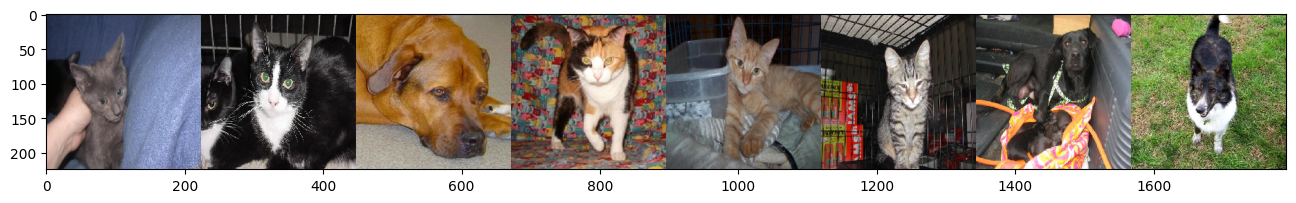

In [ ]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

# Transfer Learning com VGG16

A ideia por trás do Transfer Learning, como dito no projeto demonstração, é utilizar uma rede pré treinada (nesse caso a VGG16) removendo apenas a última ou penúltimas camadas de classificação, se aproveitando da configuração que foi utilizada para realizar o ImageNet Large Scale Visual Recognition Challenge (ILSVRC).

Primeiramente instanciamos um modelo pre treinado da rede neural convolucional VGG16 do módulo `keras.application`

*   `vgg = keras.applications.VGG16(weights='imagenet', include_top=True)` onde `weights = imagenet` declara que o modelo será carregado com os mesmos número de conexões entre os nódulos da rede neural utilizados na ILSVRC e `include_top=True` inclue também a camada de classificação softmax ao final



*The idea behind Transfer Learning, as stated in the demonstration project, is to use a pre-trained network (in this case VGG16) removing only the last or 2nd-to-last classification layers, taking advantage of the configuration that was used to perform the ImageNet Large Scale Visual Recognition Challenge (ILSVRC).*

*First, we instantiate a pre-trained model of the VGG16 convolutional neural network from the `keras.application` module*

* *`vgg = keras.applications.VGG16(weights='imagenet', include_top=True)` where `weights = imagenet` declares that the model will be loaded with the same number of connections between the neural network nodes used in ILSVRC and `include_top=True` also includes the softmax classification layer at the end*

In [ ]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

Antes de continuar com a preparação das ultimas camadas de classificação, é importante elucidar o que o algorítimo acima fará.

VGG16 é uma CNN (Rede Neural Convolucional) que detecta padrões em imagens. No nosso exemplo, alimentando o modelo com várias fotos de cães e gatos ele aprende características únicas de cada classe. Resumidamente, dado uma entrada (imagem), o modelo realiza várias séries de convoluções e agrupamentos ligadas em séries formando um grande conjunto de camadas conectadas.

`block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792` indica que o primeiro bloco após a camada de entrada realizará convoluções de 64 filtros de tamanho 3x3 em imagens de tamanho 224x224, onde o `None` indica que o tamanho do lote ainda está indefinido.

Usar duas convoluções em sequencia utilizará duas rectified linear activation function (função de ativação linear retificada) or ReLU, dando mais não-linearidade ao modelo (o cálculo é simples, retorna o valor fornecido como entrada diretamente, ou o valor 0,0 se a entrada for 0,0 ou menos, atua como uma função linear, mas é uma função não linear)

O número de filtros aumenta a medida em que vamos nos aprofundando na rede. O tamanho dos mapas de características diminue por causa dos agrupamentos (pooling), mas aumenta a profundidade de volume já que aplica-se mais filtros.

` block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0` reduz o tamanho original de 224x224 para 112x112. Isso permite reduzir o número de parâmetros, o que diminue o tempo de treinamento e evita o overfitting.

`flatten (Flatten)           (None, 25088)             0  ` converte o vetor multidimensional (por exemplo, uma matrix 3D resultante de camadas convolucionais/de agrupamento) em um vetor 1D que pode ser entregue nas fully-connected layers (denses).

`fc1 (Dense)                 (None, 4096)              102764544 ` a fully-connected layer é treinada da mesma forma que a ANN (Artifical Neural Network), usando retropropagação com descida de gradiente (backpropagation with gratient descent).

O modelo pode ser pensado como uma combinação de dois componentes: a parte de extração de características e a parte de classificação. As camadas de convolução e agrupamento realizam a extração de características. Por exemplo, dada uma imagem, a camada de convolução detecta características como dois olhos, orelhas longas, quatro pernas, uma cauda curta e assim por diante. As fully-connected layers (dense) então agem como um classificador sobre essas características e atribuem uma probabilidade para a imagem de entrada ser um cachorro.

Faremos agora a troca da camada de classificação softmax original pela nossa propria camada softmax com duas classes apenas.

*   `inp = vgg.input` indica que o novo modelo utilizará a mesma entrada que o modelo VGG16
*   `new_classification_layer = Dense(num_classes, activation='softmax')` cria uma nova fully-connected dense layer com 2 classes
*   `out = new_classification_layer(vgg.layers[-2].output)`  refere-se a penúltima camada do VGG16. A saída desta camada é usada como entrada para sua nova camada softmax.
*   `model_new = Model(inp, out)` cria o novo modelo, sendo o input igual ao inicial do VGG16 e output a nova camada softmax.



*Before continuing with the preparation of the last classification layers, it is important to clarify what the above algorithm will do.*

*VGG16 is a CNN (Convolutional Neural Network) that detects patterns in images. In our example, by feeding the model several photos of dogs and cats, it learns unique characteristics of each class. In short, given an input (image), the model performs several series of convolutions and poolings linked in series, forming a large set of connected layers.*

*`block1_conv1 (Conv2D) (None, 224, 224, 64) 1792` indicates that the first block after the input layer will perform convolutions of 64 filters of size 3x3 on images of size 224x224, where `None` indicates that the batch size is still undefined.*

*Using two convolutions in sequence will use two rectified linear activation functions or ReLU, giving more non-linearity to the model (the calculation is simple, it returns the value provided as input directly, or the value 0.0 if the input is 0.0 or less, it acts as a linear function, but it is a non-linear function).*

*The number of filters increases as we go deeper into the network. The size of the feature maps decreases because of pooling, but the depth of the volume increases since more filters are applied.*

*` block1_pool (MaxPooling2D) (None, 112, 112, 64) 0` reduces the original size from 224x224 to 112x112. This allows us to reduce the number of parameters, which reduces training time and avoids overfitting.*

*`flatten (Flatten) (None, 25088) 0 ` converts the multidimensional vector (e.g. a 3D matrix resulting from convolutional/pooling layers) into a 1D vector that can be fed to the fully-connected (dense) layers.*

*`fc1 (Dense) (None, 4096) 102764544 ` the fully-connected layer is trained in the same way as the ANN (Artificial Neural Network), using backpropagation with gradient descent.*

*The model can be thought of as a combination of two components: the feature extraction part and the classification part. The convolution and pooling layers perform the feature extraction. For example, given an image, the convolution layer detects features such as two eyes, long ears, four legs, a short tail, and so on. The fully-connected layers (dense) then act as a classifier on these features and assign a probability to the input image being a dog.*

*We will now replace the original softmax classification layer with our own softmax layer with only two classes.*

* *`inp = vgg.input` indicates that the new model will use the same input as the VGG16 model*
* *`new_classification_layer = Dense(num_classes, activation='softmax')` creates a new fully-connected dense layer with 2 classes*
* *`out = new_classification_layer(vgg.layers[-2].output)` refers to the 2nd-to-last layer of VGG16. The output of this layer is used as input to its new softmax layer.*
* *`model_new = Model(inp, out)` creates the new model, with the input being the same as the initial VGG16 model and the output being the new softmax layer.*

In [ ]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


Seguindo na linha de raciocínio do projeto demonstração, faremos o congelamento dos pesos de treinamento (número de conexões entre os nódulos), exceto pela nossa ultima camada softmax de classificação.

*Following the line of reasoning of the demonstration project, we will freeze the training weights (number of connections between nodes), except for our last softmax classification layer.*

In [ ]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

***Nota importante: reexecutei o código acima para preparar o modelo que usaremos para trabalhar com as TPUs do ambiente TPU do Google. Detalhes podem ser encontrados em [TPUs no Colab - Martin Gorner.](https://colab.research.google.com/notebooks/tpu.ipynb#scrollTo=ovFDeMgtjqW4)***

***Important Note: I've managed to re-execute the code above to prepare the model we're going to use to work with the TPUs from Google TPU enviroment. Further details can be found at [TPUs in Colab - Martin Gorner.](https://colab.research.google.com/notebooks/tpu.ipynb#scrollTo=ovFDeMgtjqW4)***

In [ ]:
with tpu_strategy.scope():
  vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
  inp = vgg.input
  new_classification_layer = Dense(num_classes, activation='softmax')
  out = new_classification_layer(vgg.layers[-2].output)
  model_new = Model(inp, out)
  for l, layer in enumerate(model_new.layers[:-1]):
      layer.trainable = False
  for l, layer in enumerate(model_new.layers[-1:]):
      layer.trainable = True

  model_new.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])


***Basta executar mode_new.fit() normalmente para treinar o modelo.***

***Just run mode_new.fit() normally to train the model.***

In [ ]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))

Epoch 1/10
137/137 [==============================] - 25s 164ms/step - loss: 0.1731 - accuracy: 0.9268 - val_loss: 0.1888 - val_accuracy: 0.9227
Epoch 2/10
137/137 [==============================] - 15s 110ms/step - loss: 0.1790 - accuracy: 0.9236 - val_loss: 0.1792 - val_accuracy: 0.9272
Epoch 3/10
137/137 [==============================] - 15s 110ms/step - loss: 0.1687 - accuracy: 0.9284 - val_loss: 0.1740 - val_accuracy: 0.9299
Epoch 4/10
137/137 [==============================] - 15s 109ms/step - loss: 0.1699 - accuracy: 0.9281 - val_loss: 0.1872 - val_accuracy: 0.9211
Epoch 5/10
137/137 [==============================] - 16s 120ms/step - loss: 0.1698 - accuracy: 0.9267 - val_loss: 0.1908 - val_accuracy: 0.9213
Epoch 6/10
137/137 [==============================] - 15s 110ms/step - loss: 0.1748 - accuracy: 0.9262 - val_loss: 0.1750 - val_accuracy: 0.9269
Epoch 7/10
137/137 [==============================] - 15s 109ms/step - loss: 0.1646 - accuracy: 0.9307 - val_loss: 0.1749 - val_ac

Testando para ver quantos porcento o modelo está prevendo corretamente

Testing to see the percentage the model is predicting correct

In [ ]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.1677505224943161
Test accuracy: 0.9301333427429199


Agora podemos usar o grupo de teste para prever nossas imagens conforme abaixo

We can now use the test group to predict our images as below

1/1 [==============================] - 0s 424ms/step


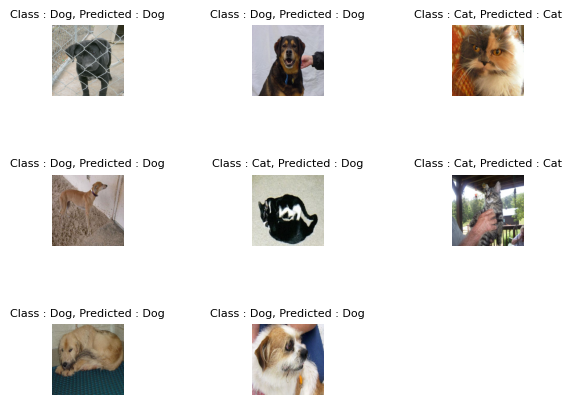

In [ ]:
def show(imgs,imgs_pxl,categories,predicted_classes_labels,i):
  plt.subplot(331+i)
  plt.axis('off')
  plt.imshow(imgs_pxl[i])
  plt.title(f'Class : {categories[imgs[i]["y"]].split("/")[1]}, Predicted : {predicted_classes_labels[i]}', fontsize=8)
  plt.subplots_adjust(wspace=1.1, hspace=1.1)

images = [int(len(test) * random.random()) for i in range(8)]
imgs = [test[images[i]] for i in range(8)]
image_paths = [img['img'] for img in imgs]
imgs_pxl = [image.load_img(image_paths[i], target_size=(224, 224)) for i in range(8)]

predictions = [model_new.predict(np.expand_dims(img['x'], axis=0), ) for img in imgs]
predcited_classes_indexes = [np.argmax(prediction) for prediction in predictions]
predicted_classes_labels = [categories[index].split('/')[1] for index in predcited_classes_indexes]

for i in range(8):
  if imgs[i]['y'] == predcited_classes_indexes[i]:
    show(imgs,imgs_pxl,categories,predicted_classes_labels,i)
  else:
    show(imgs,imgs_pxl,categories,predicted_classes_labels,i)

O que poderia ser feito para aumentar a precisão do modelo?

Considerando que aumentar o número de treimentos não elevará a precisão do modelo (pode resultar em overffiting), o que poderíamos fazer para melhorar o modelo seria usar outro modelo pré-treinado como RESnet ou Xception, ambos alcançando cerca de 3% de erro nas previsões top-5. O data augmentation e a inclusão de camadas de dropout também poderiam ser implementados em nosso modelo VGG16 para maior precisão.

Aqui já alcançamos 93% de taxa de previsão top-1, o que é impressionante para um modelo com apenas 16 camadas de treinamento em um conjunto de dados de tamanho médio.

*What could be done to increase the model accuracy?*

*Considering that increasing the number of epochs will note elevate the model accuracy (it could result in overffiting), what we could aim to enhance the model would be using another pre-trained model like RESnet or Xception, both achieving around 3% error in top-5 predictions. Data augmentation and droupout layers could as well be implemented in our VGG16 model for increased accuracy.*

*Here we already achieved 93% top-1 prediction rate, what is impressive for a model with only 16 layers traning on a medium size dataset.*

# Referências

[***Applied Deep Learning - Part 4: Convolutional Neural Networks -
Arden Dertat***](https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2)

[***A Gentle Introduction to the Rectified Linear Unit (ReLU) -  Jason Brownlee***](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/)

[***TPUs in Colab -  Martin Gorner***](https://colab.research.google.com/notebooks/tpu.ipynb#scrollTo=ovFDeMgtjqW4)

